In [11]:
import os, glob
import numpy as np
import pandas as pd
from utils import convertImage

SIZE = 512

trajectoryAugmentataionDir = '/Users/grape/GitHub/Trajectory-Augmentation/'
trajectoryDataDir = '/Users/grape/GitHub/Trajectory_Data/'

currDir = trajectoryAugmentataionDir + 'script/'
dataDir = trajectoryDataDir + 'VirtualData/'

In [2]:
os.chdir( dataDir )
files = glob.glob( '*csv' )

trainSize = int( len( files ) * 0.8 )
trainFiles, testFiles = files[ : trainSize], files[trainSize : ]

X_train, Y_train = [ ], [ ]
for file in trainFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = convertImage.coorMaxMin( csv_file )
	X_train.append( convertImage.map2Image_remove( *maxmin, csv_file ) )
	Y_train.append( convertImage.map2Image( *maxmin, csv_file ) )

X_test = [ ]
for file in testFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = convertImage.coorMaxMin( csv_file )
	X_test.append( convertImage.map2Image_remove( *maxmin, csv_file ) )

In [3]:
X_train, Y_train = np.array( X_train ), np.array( Y_train )
X_test = np.array( X_test )

X_train = X_train / 255.
Y_train = Y_train / 255.
X_test = X_test / 255.

X_train = np.reshape( X_train, ( len( X_train ), SIZE, SIZE, 1 ) )
Y_train = np.reshape( Y_train, ( len( Y_train ), SIZE, SIZE, 1 ) )
X_test = np.reshape( X_test, ( len( X_test ), SIZE, SIZE, 1 ) )

In [4]:
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

def ComputeLatent( x ):
	mu, sigma = x
	eps = K.random_normal( shape = ( K.shape( mu )[0], K.int_shape( mu )[1] ) )

	return mu + K.exp( sigma / 2 ) * eps

latent = 2

In [5]:
encoder_input = layers.Input( shape = ( SIZE, SIZE, 1 ) )
encoder_conv = layers.Conv2D( 128, 3, 2, 'same', activation = 'relu' )( encoder_input )
encoder_conv = layers.Conv2D( 256, 3, 2, 'same', activation = 'relu' )( encoder_conv )

encoder = layers.Flatten()( encoder_conv )

mu = layers.Dense( latent )( encoder )
sigma = layers.Dense( latent )( encoder )

latent_space = layers.Lambda( ComputeLatent, output_shape = ( latent, ) )( [ mu, sigma ] )

conv_shape = K.int_shape( encoder_conv )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
decoder_input = layers.Input( shape = ( latent, ) )

units = conv_shape[1] * conv_shape[2] * conv_shape[3]
decoder = layers.Dense( units, 'relu' )( decoder_input )
decoder = layers.Reshape( ( conv_shape[1], conv_shape[2], conv_shape[3] ) )( decoder )

decoder_conv = layers.Conv2DTranspose( 256, 3, 2, 'same', activation = 'relu' )( decoder )
decoder_conv = layers.Conv2DTranspose( 128, 3, 2, 'same', activation = 'relu' )( decoder_conv )
decoder_output = layers.Conv2DTranspose( 1, 3, padding = 'same', activation = 'sigmoid' )( decoder_conv )

In [7]:
encoder = keras.models.Model( encoder_input, latent_space, name = 'Encoder' )
decoder = keras.models.Model( decoder_input, decoder_output, name = 'Decoder' )

vae = keras.models.Model( encoder_input, decoder( encoder( encoder_input ) ), name = 'VAE' )

encoder.summary()
decoder.summary()
vae.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 256 295168      conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4194304)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
def KL_Reconstruction_Loss( true, pred ):
	reconstruction_loss = keras.losses.binary_crossentropy( K.flatten( true ), K.flatten( pred ) ) * SIZE * SIZE

	kl_loss = 1 + sigma - K.square( mu ) - K.exp( sigma )
	kl_loss = K.sum( kl_loss, axis = -1 )
	kl_loss *= -0.5

	return K.mean( reconstruction_loss + kl_loss )

vae.compile( 'adam', KL_Reconstruction_Loss )

In [9]:
BATCH_SIZE = 10
EPOCHS = 30

history = vae.fit( X_train, Y_train, BATCH_SIZE, EPOCHS )

Train on 52 samples
Epoch 1/30
52/52 [==============================] - 79s 2s/sample - loss: nan
Epoch 2/30
52/52 [==============================] - 82s 2s/sample - loss: nan
Epoch 3/30
52/52 [==============================] - 77s 1s/sample - loss: nan
Epoch 4/30
52/52 [==============================] - 71s 1s/sample - loss: nan
Epoch 5/30
52/52 [==============================] - 80s 2s/sample - loss: nan
Epoch 6/30
52/52 [==============================] - 74s 1s/sample - loss: nan
Epoch 7/30
52/52 [==============================] - 75s 1s/sample - loss: nan
Epoch 8/30
52/52 [==============================] - 78s 1s/sample - loss: nan
Epoch 9/30
52/52 [==============================] - 77s 1s/sample - loss: nan
Epoch 10/30
52/52 [==============================] - 80s 2s/sample - loss: nan
Epoch 11/30
52/52 [==============================] - 79s 2s/sample - loss: nan
Epoch 12/30
52/52 [==============================] - 73s 1s/sample - loss: nan
Epoch 13/30
52/52 [======================

/Users/grape/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/grape/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/grape/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/grape/opt/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/grape/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


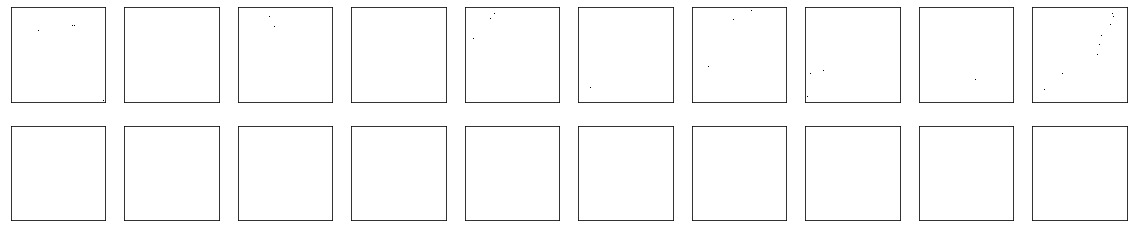

In [12]:
decoded_img = vae.predict( X_test )

import matplotlib.pyplot as plt

os.chdir( currDir )

n = 10
plt.figure( figsize = ( 20, 4 ) )
for i in range( n ):
	ax = plt.subplot( 2, n, i + 1 )
	plt.imshow( X_test[i].reshape( SIZE, SIZE ) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

	ax = plt.subplot( 2, n, n + i + 1 )
	plt.imshow( decoded_img[i].reshape( SIZE, SIZE ) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

plt.savefig( 'Result.png', dpi = 300 )
plt.show()